<a href="https://colab.research.google.com/github/ab2gbl/ECG-detection/blob/main/QRS_detection/TCN/Test_of_TCN_QTDB%2BLUDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# functions

In [3]:
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org' '/content/physionet.org'

In [2]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 23.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [4]:
import wfdb
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.signal import resample
from re import S
import os

In [5]:
def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=250, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
def smooth_signal(data, window_size=5):
    # Smooth the signal using a moving average filter
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed

In [6]:


def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal


def adjust_annotations(samples, original_fs, target_fs):
    return (samples * target_fs / original_fs).astype(int)



In [7]:

def create_binary_mask(signal, qrs_regions):
    mask = np.zeros(len(signal))
    for start, end in qrs_regions:
        mask[start:end] = 1  # Mark QRS regions as 1
    return mask


In [8]:
def segment_signal_and_mask(signal, mask, window_size, fs):
    segments = []
    masks = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        mask_segment = mask[i:i + window_size]
        segments.append(segment)
        masks.append(mask_segment)
    return np.array(segments), np.array(masks)


In [51]:
def normalize_signal(data):
    """
    Normalize the signal using z-score normalization.
    """
    return (data - np.mean(data)) / np.std(data)

# signal 100 MITDB

In [25]:
import wfdb

# Load the new ECG signal
new_record = wfdb.rdrecord('/content/physionet.org/files/mitdb/1.0.0/100')

new_signal = new_record.p_signal[:, 0]  # Use lead I
new_fs = new_record.fs  # Sampling frequency

# Extract the first 10 seconds
first_10_seconds = new_signal[:int(10 * new_fs)]
print(first_10_seconds.shape)

(3600,)


In [26]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

first_10_seconds = smooth_signal(bandpass_filter(first_10_seconds))

first_10_seconds = resample_signal(first_10_seconds, original_fs=new_fs, target_fs=250)
new_fs=250
# Segment the signal into fixed-length windows
def segment_signal(signal, window_size, fs):
    segments = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        segments.append(segment)
    return np.array(segments)

window_size = int(1 * new_fs)  # 1-second window
new_segments = segment_signal(first_10_seconds, window_size, new_fs)

# Reshape for TCN input
new_segments = new_segments.reshape(-1, window_size, 1)
print(new_segments.shape)

(18, 250, 1)


## First Model

In [27]:
from keras.saving import save_model,load_model

# Save the trained model
model=load_model("/content/drive/MyDrive/Final project/QRS detection/TCN/First_model.keras")

In [28]:
# Predict QRS regions
y_pred = model.predict(new_segments)
print(y_pred)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary masks
print(y_pred[y_pred > 0])  # P
# Combine predictions into a single mask
full_mask = np.zeros(len(first_10_seconds))
for i, segment in enumerate(new_segments):
    start = i * (window_size // 2)
    end = start + window_size
    full_mask[start:end] = np.maximum(full_mask[start:end], y_pred[i].flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
[[[0.04339973]
  [0.01087366]
  [0.11412656]
  ...
  [0.1979068 ]
  [0.4049927 ]
  [0.5308791 ]]

 [[0.05442181]
  [0.06241623]
  [0.41377687]
  ...
  [0.00983207]
  [0.0070288 ]
  [0.00162885]]

 [[0.10107104]
  [0.41793078]
  [0.43418077]
  ...
  [0.01250339]
  [0.126473  ]
  [0.03712638]]

 ...

 [[0.04319881]
  [0.5262714 ]
  [0.4834273 ]
  ...
  [0.01090193]
  [0.01501592]
  [0.00187272]]

 [[0.04001701]
  [0.06031278]
  [0.05520411]
  ...
  [0.0849312 ]
  [0.20354816]
  [0.12968956]]

 [[0.04930029]
  [0.09670402]
  [0.12799159]
  ...
  [0.00566797]
  [0.00279431]
  [0.00147595]]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [29]:
def extract_qrs_from_mask(mask):
    qrs_regions = []
    start = None
    for i in range(len(mask)):
        if mask[i] == 1 and start is None:  # Start of QRS region
            start = i
        elif mask[i] == 0 and start is not None:  # End of QRS region
            end = i
            qrs_regions.append((start, end))
            start = None
    return qrs_regions

qrs_regions = extract_qrs_from_mask(full_mask)
print(qrs_regions)

[(45, 64), (65, 66), (244, 245), (249, 268), (269, 271), (451, 452), (453, 471), (472, 473), (642, 643), (644, 647), (649, 668), (669, 671), (848, 865), (1040, 1041), (1045, 1062), (1127, 1129), (1249, 1267), (1268, 1270), (1410, 1417), (1419, 1430), (1431, 1433), (1655, 1658), (1662, 1681), (1682, 1683), (1752, 1753), (1868, 1890), (1891, 1892), (2053, 2054), (2071, 2092), (2093, 2095), (2269, 2272), (2273, 2290), (2291, 2293)]


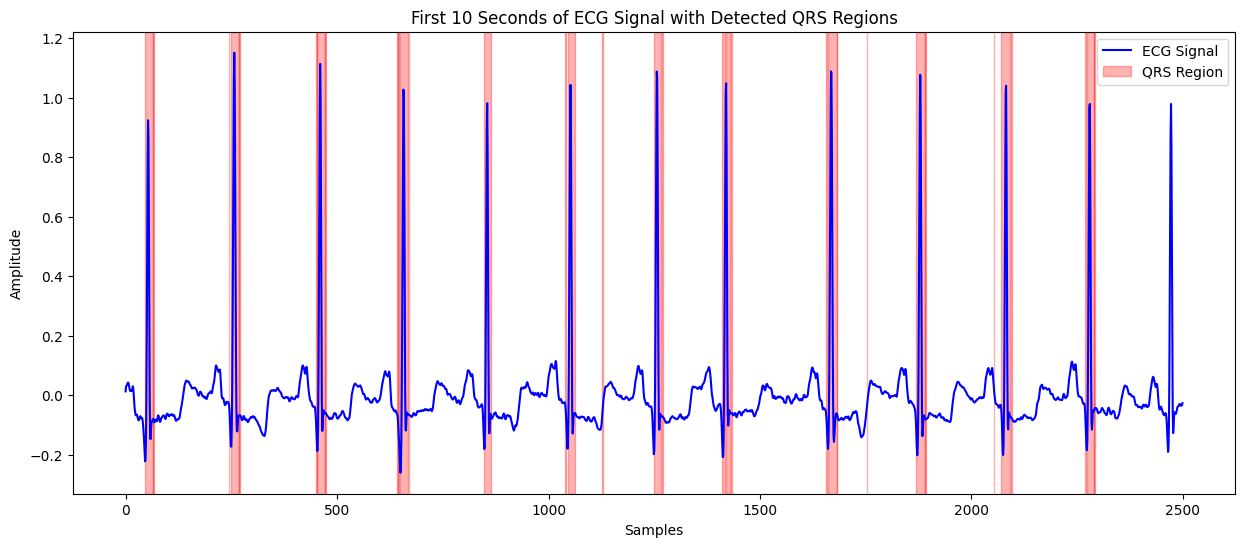

In [30]:
import matplotlib.pyplot as plt

# Plot the first 10 seconds of the ECG signal
plt.figure(figsize=(15, 6))
plt.plot(first_10_seconds, label='ECG Signal', color='b')

# Highlight QRS regions
for start, end in qrs_regions:
    plt.axvspan(start, end, color='r', alpha=0.3, label='QRS Region' if start == qrs_regions[0][0] else "")

plt.title('First 10 Seconds of ECG Signal with Detected QRS Regions')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
#plt.plot(y_pred[0].flatten(), label='Predicted Mask')
plt.legend()
plt.show()

## 4s input model

In [31]:
model2=load_model("/content/drive/MyDrive/Final project/QRS detection/TCN/TCN_4s_model.keras")

In [32]:
# Predict QRS regions
y_pred = model.predict(new_segments)
print(y_pred)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary masks
print(y_pred[y_pred > 0])  # P
# Combine predictions into a single mask
full_mask = np.zeros(len(first_10_seconds))
for i, segment in enumerate(new_segments):
    start = i * (window_size // 2)
    end = start + window_size
    full_mask[start:end] = np.maximum(full_mask[start:end], y_pred[i].flatten())



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
[[[0.04339973]
  [0.01087366]
  [0.11412656]
  ...
  [0.1979068 ]
  [0.4049927 ]
  [0.5308791 ]]

 [[0.05442181]
  [0.06241623]
  [0.41377687]
  ...
  [0.00983207]
  [0.0070288 ]
  [0.00162885]]

 [[0.10107104]
  [0.41793078]
  [0.43418077]
  ...
  [0.01250339]
  [0.126473  ]
  [0.03712638]]

 ...

 [[0.04319881]
  [0.5262714 ]
  [0.4834273 ]
  ...
  [0.01090193]
  [0.01501592]
  [0.00187272]]

 [[0.04001701]
  [0.06031278]
  [0.05520411]
  ...
  [0.0849312 ]
  [0.20354816]
  [0.12968956]]

 [[0.04930029]
  [0.09670402]
  [0.12799159]
  ...
  [0.00566797]
  [0.00279431]
  [0.00147595]]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [33]:
qrs_regions = extract_qrs_from_mask(full_mask)
print(qrs_regions)

[(45, 64), (65, 66), (244, 245), (249, 268), (269, 271), (451, 452), (453, 471), (472, 473), (642, 643), (644, 647), (649, 668), (669, 671), (848, 865), (1040, 1041), (1045, 1062), (1127, 1129), (1249, 1267), (1268, 1270), (1410, 1417), (1419, 1430), (1431, 1433), (1655, 1658), (1662, 1681), (1682, 1683), (1752, 1753), (1868, 1890), (1891, 1892), (2053, 2054), (2071, 2092), (2093, 2095), (2269, 2272), (2273, 2290), (2291, 2293)]


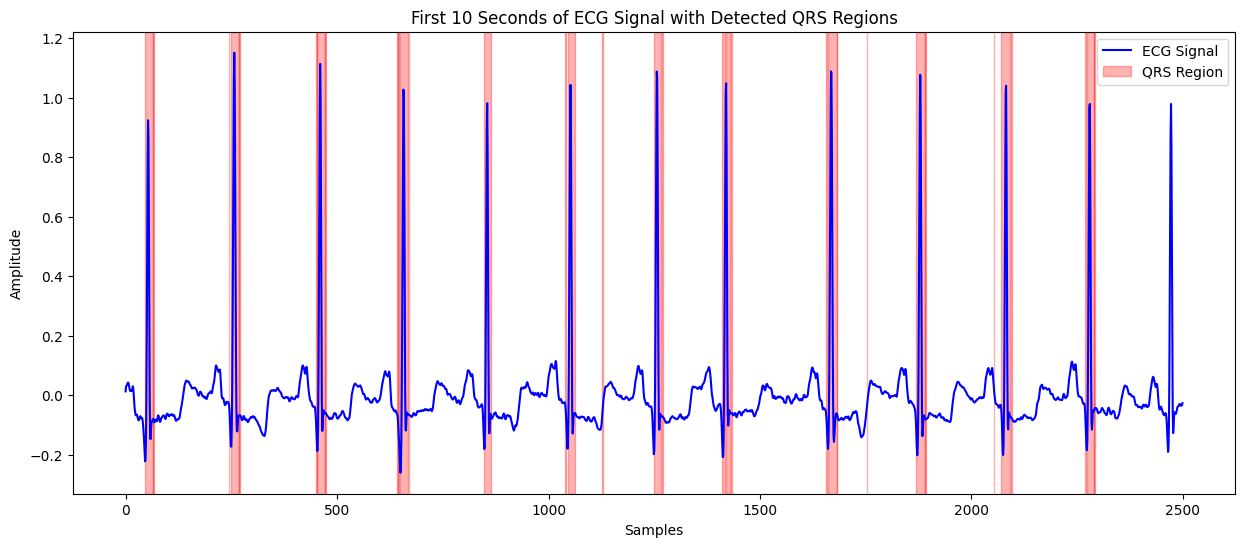

In [34]:
# Plot the first 10 seconds of the ECG signal
plt.figure(figsize=(15, 6))
plt.plot(first_10_seconds, label='ECG Signal', color='b')

# Highlight QRS regions
for start, end in qrs_regions:
    plt.axvspan(start, end, color='r', alpha=0.3, label='QRS Region' if start == qrs_regions[0][0] else "")

plt.title('First 10 Seconds of ECG Signal with Detected QRS Regions')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
#plt.plot(y_pred[0].flatten(), label='Predicted Mask')
plt.legend()
plt.show()

# signal MIT-DB 108

In [41]:

# Load the new ECG signal
new_record = wfdb.rdrecord('/content/physionet.org/files/mitdb/1.0.0/108')

new_signal = new_record.p_signal[:, 0]  # Use lead I
new_fs = new_record.fs  # Sampling frequency

# Extract the first 10 seconds
first_10_seconds = new_signal[:int(10 * new_fs)]
print(first_10_seconds.shape)

(3600,)


In [42]:

first_10_seconds = smooth_signal(bandpass_filter(first_10_seconds))

first_10_seconds = resample_signal(first_10_seconds, original_fs=new_fs, target_fs=250)
new_fs=250
# Segment the signal into fixed-length windows
def segment_signal(signal, window_size, fs):
    segments = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        segments.append(segment)
    return np.array(segments)

window_size = int(1 * new_fs)  # 1-second window
new_segments = segment_signal(first_10_seconds, window_size, new_fs)

# Reshape for TCN input
new_segments = new_segments.reshape(-1, window_size, 1)
print(new_segments.shape)

(18, 250, 1)


## First Model

In [43]:
from keras.saving import save_model,load_model

# Save the trained model
model=load_model("/content/drive/MyDrive/Final project/QRS detection/TCN/First_model.keras")

In [44]:
# Predict QRS regions
y_pred = model.predict(new_segments)
print(y_pred)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary masks
print(y_pred[y_pred > 0])  # P
# Combine predictions into a single mask
full_mask = np.zeros(len(first_10_seconds))
for i, segment in enumerate(new_segments):
    start = i * (window_size // 2)
    end = start + window_size
    full_mask[start:end] = np.maximum(full_mask[start:end], y_pred[i].flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[[0.03819644]
  [0.0303735 ]
  [0.04449879]
  ...
  [0.00696825]
  [0.00650889]
  [0.00495792]]

 [[0.06101317]
  [0.02698541]
  [0.05389747]
  ...
  [0.0754874 ]
  [0.00879101]
  [0.00914224]]

 [[0.06695456]
  [0.02845554]
  [0.04570149]
  ...
  [0.03623782]
  [0.08801826]
  [0.01569258]]

 ...

 [[0.050473  ]
  [0.05174737]
  [0.14843242]
  ...
  [0.01420233]
  [0.06486253]
  [0.02010993]]

 [[0.23113489]
  [0.26068735]
  [0.09349216]
  ...
  [0.04927361]
  [0.06011712]
  [0.09384211]]

 [[0.04213768]
  [0.13588187]
  [0.07454974]
  ...
  [0.10593583]
  [0.14650173]
  [0.01762418]]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [45]:
def extract_qrs_from_mask(mask):
    qrs_regions = []
    start = None
    for i in range(len(mask)):
        if mask[i] == 1 and start is None:  # Start of QRS region
            start = i
        elif mask[i] == 0 and start is not None:  # End of QRS region
            end = i
            qrs_regions.append((start, end))
            start = None
    return qrs_regions

qrs_regions = extract_qrs_from_mask(full_mask)
print(qrs_regions)

[(11, 14), (70, 71), (72, 73), (196, 197), (299, 300), (308, 320), (536, 539), (541, 542), (551, 562), (805, 815), (925, 926), (1023, 1029), (1040, 1050), (1147, 1149), (1225, 1226), (1231, 1235), (1252, 1255), (1270, 1278), (1381, 1382), (1390, 1391), (1485, 1490), (1504, 1511), (1627, 1630), (1733, 1739), (1753, 1761), (1956, 1957), (1993, 1998), (2012, 2020), (2235, 2242), (2252, 2253), (2254, 2261)]


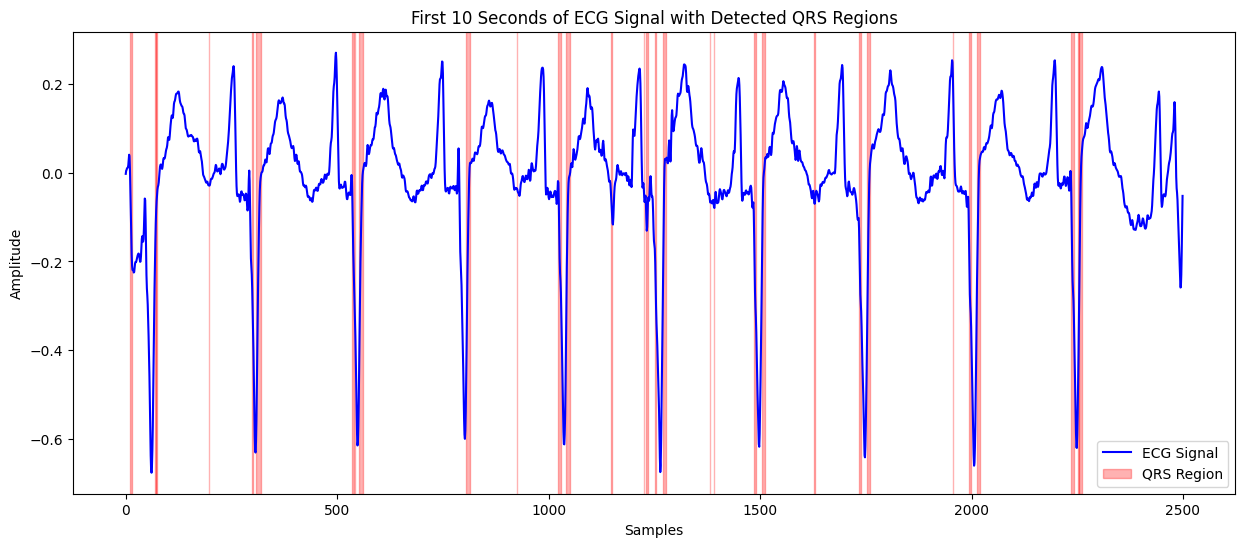

In [46]:
import matplotlib.pyplot as plt

# Plot the first 10 seconds of the ECG signal
plt.figure(figsize=(15, 6))
plt.plot(first_10_seconds, label='ECG Signal', color='b')

# Highlight QRS regions
for start, end in qrs_regions:
    plt.axvspan(start, end, color='r', alpha=0.3, label='QRS Region' if start == qrs_regions[0][0] else "")

plt.title('First 10 Seconds of ECG Signal with Detected QRS Regions')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
#plt.plot(y_pred[0].flatten(), label='Predicted Mask')
plt.legend()
plt.show()

## 4s input model

In [47]:
model2=load_model("/content/drive/MyDrive/Final project/QRS detection/TCN/TCN_4s_model.keras")

In [48]:
# Predict QRS regions
y_pred = model.predict(new_segments)
print(y_pred)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary masks
print(y_pred[y_pred > 0])  # P
# Combine predictions into a single mask
full_mask = np.zeros(len(first_10_seconds))
for i, segment in enumerate(new_segments):
    start = i * (window_size // 2)
    end = start + window_size
    full_mask[start:end] = np.maximum(full_mask[start:end], y_pred[i].flatten())



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
[[[0.03819644]
  [0.0303735 ]
  [0.04449879]
  ...
  [0.00696825]
  [0.00650889]
  [0.00495792]]

 [[0.06101317]
  [0.02698541]
  [0.05389747]
  ...
  [0.0754874 ]
  [0.00879101]
  [0.00914224]]

 [[0.06695456]
  [0.02845554]
  [0.04570149]
  ...
  [0.03623782]
  [0.08801826]
  [0.01569258]]

 ...

 [[0.050473  ]
  [0.05174737]
  [0.14843242]
  ...
  [0.01420233]
  [0.06486253]
  [0.02010993]]

 [[0.23113489]
  [0.26068735]
  [0.09349216]
  ...
  [0.04927361]
  [0.06011712]
  [0.09384211]]

 [[0.04213768]
  [0.13588187]
  [0.07454974]
  ...
  [0.10593583]
  [0.14650173]
  [0.01762418]]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [49]:
qrs_regions = extract_qrs_from_mask(full_mask)
print(qrs_regions)

[(11, 14), (70, 71), (72, 73), (196, 197), (299, 300), (308, 320), (536, 539), (541, 542), (551, 562), (805, 815), (925, 926), (1023, 1029), (1040, 1050), (1147, 1149), (1225, 1226), (1231, 1235), (1252, 1255), (1270, 1278), (1381, 1382), (1390, 1391), (1485, 1490), (1504, 1511), (1627, 1630), (1733, 1739), (1753, 1761), (1956, 1957), (1993, 1998), (2012, 2020), (2235, 2242), (2252, 2253), (2254, 2261)]


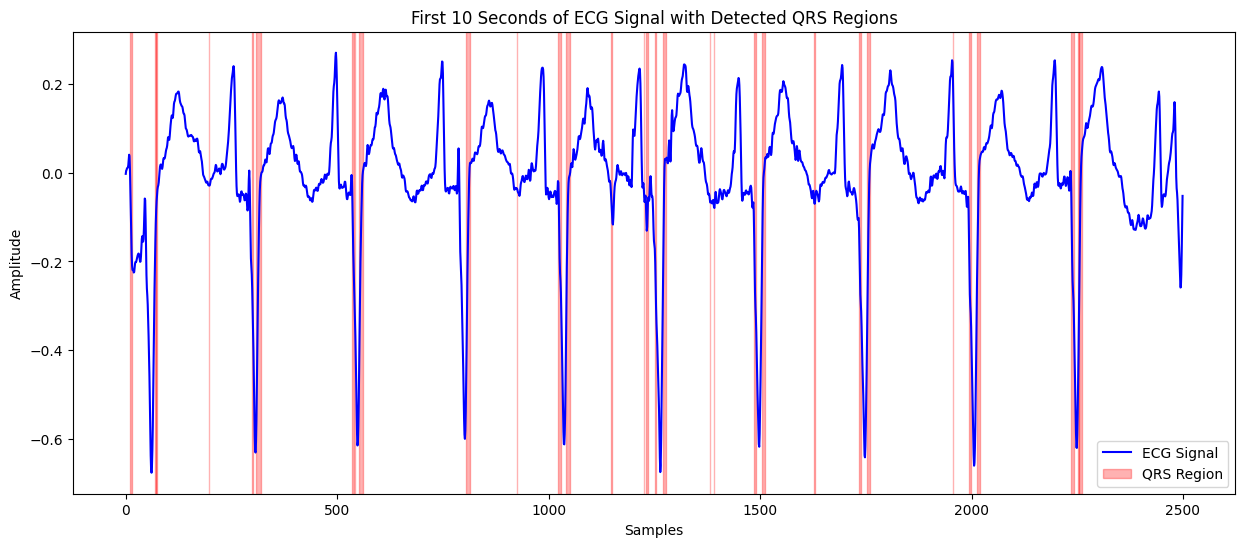

In [50]:
# Plot the first 10 seconds of the ECG signal
plt.figure(figsize=(15, 6))
plt.plot(first_10_seconds, label='ECG Signal', color='b')

# Highlight QRS regions
for start, end in qrs_regions:
    plt.axvspan(start, end, color='r', alpha=0.3, label='QRS Region' if start == qrs_regions[0][0] else "")

plt.title('First 10 Seconds of ECG Signal with Detected QRS Regions')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
#plt.plot(y_pred[0].flatten(), label='Predicted Mask')
plt.legend()
plt.show()

# signal MIT-DB 100 normalized

In [99]:

# Load the new ECG signal
new_record = wfdb.rdrecord('/content/physionet.org/files/mitdb/1.0.0/100')

new_signal = new_record.p_signal[:, 0]  # Use lead I
new_fs = new_record.fs  # Sampling frequency

# Extract the first 10 seconds
first_10_seconds = new_signal[:int(10 * new_fs)]
print(first_10_seconds.shape)

(3600,)


In [100]:

first_10_seconds = normalize_signal(smooth_signal(bandpass_filter(first_10_seconds)))

first_10_seconds = resample_signal(first_10_seconds, original_fs=new_fs, target_fs=250)
new_fs=250
# Segment the signal into fixed-length windows
def segment_signal(signal, window_size, fs):
    segments = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        segments.append(segment)
    return np.array(segments)

window_size = int(1 * new_fs)  # 1-second window
new_segments = segment_signal(first_10_seconds, window_size, new_fs)

# Reshape for TCN input
new_segments = new_segments.reshape(-1, window_size, 1)
print(new_segments.shape)

(18, 250, 1)


## Norm Model

In [101]:
from keras.saving import save_model,load_model

# Save the trained model
model=load_model("/content/drive/MyDrive/Final project/QRS detection/TCN/Norm_model.keras")

In [102]:
# Predict QRS regions
y_pred = model.predict(new_segments)
print(y_pred)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary masks
print(y_pred[y_pred > 0])  # P
# Combine predictions into a single mask
full_mask = np.zeros(len(first_10_seconds))
for i, segment in enumerate(new_segments):
    start = i * (window_size // 2)
    end = start + window_size
    full_mask[start:end] = np.maximum(full_mask[start:end], y_pred[i].flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
[[[4.1625779e-02]
  [1.0758641e-01]
  [2.7572545e-01]
  ...
  [7.5691491e-01]
  [7.3101646e-01]
  [8.3085388e-01]]

 [[7.3365420e-02]
  [5.1742636e-02]
  [2.3103464e-02]
  ...
  [9.6887193e-04]
  [4.5152495e-04]
  [5.0998828e-04]]

 [[1.2954542e-01]
  [6.0889012e-01]
  [6.2986767e-01]
  ...
  [1.9981423e-03]
  [3.3793431e-03]
  [3.0730010e-03]]

 ...

 [[6.0534649e-02]
  [8.1616884e-01]
  [9.3401152e-01]
  ...
  [4.4634934e-03]
  [6.3188118e-03]
  [1.2936218e-03]]

 [[2.8931055e-02]
  [1.1112079e-02]
  [2.7958598e-02]
  ...
  [5.4505439e-03]
  [1.2044448e-02]
  [2.1166690e-02]]

 [[6.4811282e-02]
  [3.2116178e-02]
  [4.6024032e-02]
  ...
  [1.5296553e-03]
  [3.9993017e-04]
  [6.4701890e-04]]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [103]:
def extract_qrs_from_mask(mask):
    qrs_regions = []
    start = None
    for i in range(len(mask)):
        if mask[i] == 1 and start is None:  # Start of QRS region
            start = i
        elif mask[i] == 0 and start is not None:  # End of QRS region
            end = i
            qrs_regions.append((start, end))
            start = None
    return qrs_regions

qrs_regions = extract_qrs_from_mask(full_mask)
print(qrs_regions)

[(46, 51), (54, 62), (247, 264), (453, 456), (457, 460), (461, 468), (645, 665), (845, 846), (847, 864), (1043, 1047), (1049, 1051), (1053, 1061), (1249, 1264), (1411, 1412), (1413, 1419), (1422, 1427), (1661, 1662), (1663, 1664), (1665, 1669), (1670, 1674), (1869, 1870), (1873, 1888), (2073, 2077), (2078, 2089), (2273, 2287)]


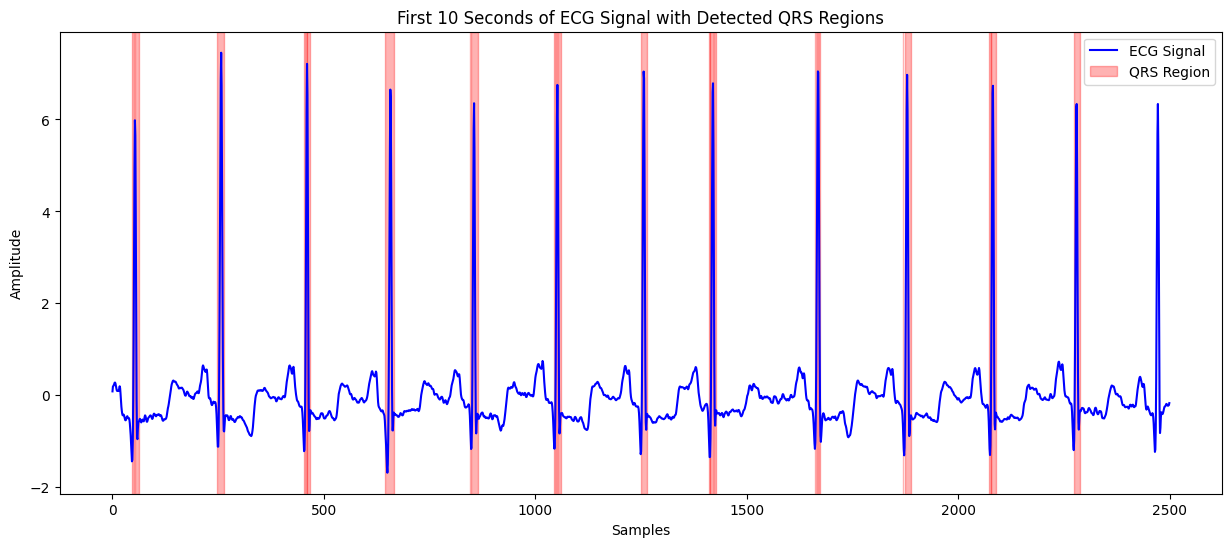

In [104]:
import matplotlib.pyplot as plt

# Plot the first 10 seconds of the ECG signal
plt.figure(figsize=(15, 6))
plt.plot(first_10_seconds, label='ECG Signal', color='b')

# Highlight QRS regions
for start, end in qrs_regions:
    plt.axvspan(start, end, color='r', alpha=0.3, label='QRS Region' if start == qrs_regions[0][0] else "")

plt.title('First 10 Seconds of ECG Signal with Detected QRS Regions')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
#plt.plot(y_pred[0].flatten(), label='Predicted Mask')
plt.legend()
plt.show()

# signal MIT-DB 108 normalized

In [59]:

# Load the new ECG signal
new_record = wfdb.rdrecord('/content/physionet.org/files/mitdb/1.0.0/108')

new_signal = new_record.p_signal[:, 0]  # Use lead I
new_fs = new_record.fs  # Sampling frequency

# Extract the first 10 seconds
first_10_seconds = new_signal[:int(10 * new_fs)]
print(first_10_seconds.shape)

(3600,)


In [60]:

first_10_seconds = normalize_signal(smooth_signal(bandpass_filter(first_10_seconds)))

first_10_seconds = resample_signal(first_10_seconds, original_fs=new_fs, target_fs=250)
new_fs=250
# Segment the signal into fixed-length windows
def segment_signal(signal, window_size, fs):
    segments = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        segments.append(segment)
    return np.array(segments)

window_size = int(1 * new_fs)  # 1-second window
new_segments = segment_signal(first_10_seconds, window_size, new_fs)

# Reshape for TCN input
new_segments = new_segments.reshape(-1, window_size, 1)
print(new_segments.shape)

(18, 250, 1)


## First Model

In [61]:
from keras.saving import save_model,load_model

# Save the trained model
model=load_model("/content/drive/MyDrive/Final project/QRS detection/TCN/Norm_model.keras")

In [62]:
# Predict QRS regions
y_pred = model.predict(new_segments)
print(y_pred)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary masks
print(y_pred[y_pred > 0])  # P
# Combine predictions into a single mask
full_mask = np.zeros(len(first_10_seconds))
for i, segment in enumerate(new_segments):
    start = i * (window_size // 2)
    end = start + window_size
    full_mask[start:end] = np.maximum(full_mask[start:end], y_pred[i].flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[[3.0031582e-02]
  [2.9439511e-02]
  [8.7638177e-02]
  ...
  [8.6950315e-03]
  [3.6049560e-03]
  [3.3368561e-03]]

 [[1.1715537e-01]
  [2.1660611e-02]
  [2.4499709e-02]
  ...
  [7.8403926e-04]
  [5.9547403e-04]
  [7.5728144e-04]]

 [[1.2725711e-01]
  [2.6592096e-02]
  [2.9887192e-02]
  ...
  [1.0991643e-02]
  [2.1003921e-02]
  [1.9698381e-02]]

 ...

 [[6.4455368e-02]
  [6.4379439e-02]
  [3.1902034e-02]
  ...
  [7.8902644e-04]
  [6.9606840e-04]
  [9.0372552e-05]]

 [[2.8959996e-01]
  [3.7469727e-01]
  [1.8075350e-01]
  ...
  [1.4744341e-01]
  [6.0272366e-01]
  [7.0809793e-01]]

 [[4.4114392e-02]
  [2.6139500e-02]
  [1.0232107e-02]
  ...
  [8.5083619e-03]
  [4.8776437e-03]
  [2.8223712e-03]]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [63]:
def extract_qrs_from_mask(mask):
    qrs_regions = []
    start = None
    for i in range(len(mask)):
        if mask[i] == 1 and start is None:  # Start of QRS region
            start = i
        elif mask[i] == 0 and start is not None:  # End of QRS region
            end = i
            qrs_regions.append((start, end))
            start = None
    return qrs_regions

qrs_regions = extract_qrs_from_mask(full_mask)
print(qrs_regions)

[(12, 13), (20, 21), (65, 66), (303, 307), (308, 313), (314, 319), (536, 537), (538, 539), (552, 554), (557, 561), (794, 795), (801, 802), (803, 804), (811, 815), (1002, 1003), (1024, 1028), (1030, 1031), (1033, 1034), (1036, 1037), (1038, 1040), (1047, 1049), (1201, 1202), (1225, 1226), (1252, 1257), (1269, 1274), (1486, 1493), (1499, 1500), (1503, 1507), (1735, 1741), (1752, 1761), (1993, 1999), (2000, 2001), (2004, 2008), (2010, 2014), (2015, 2019), (2238, 2241), (2242, 2244), (2248, 2251), (2254, 2255)]


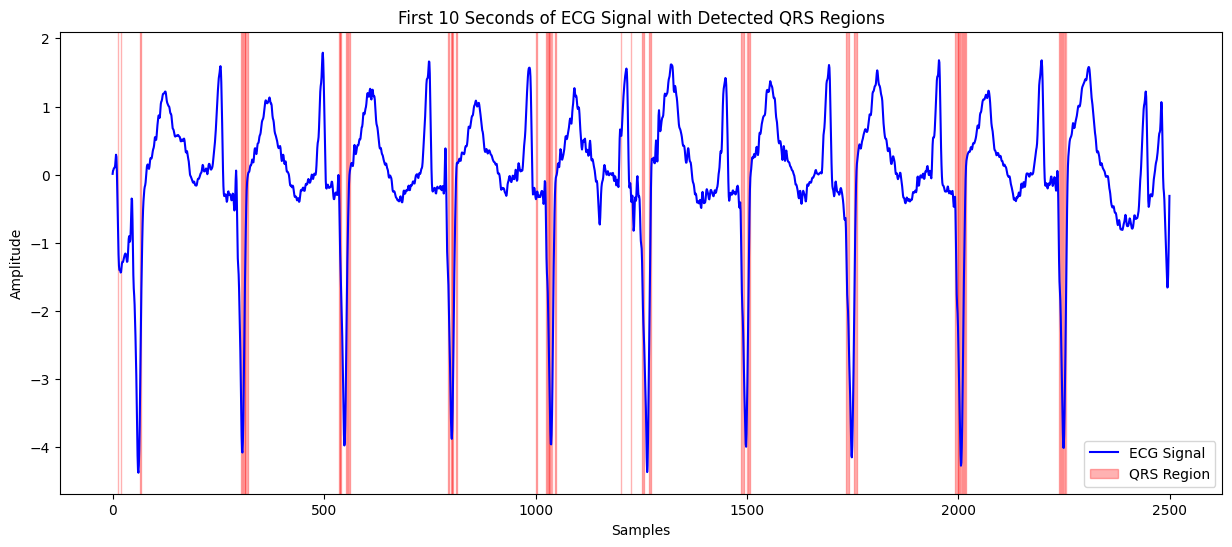

In [64]:
import matplotlib.pyplot as plt

# Plot the first 10 seconds of the ECG signal
plt.figure(figsize=(15, 6))
plt.plot(first_10_seconds, label='ECG Signal', color='b')

# Highlight QRS regions
for start, end in qrs_regions:
    plt.axvspan(start, end, color='r', alpha=0.3, label='QRS Region' if start == qrs_regions[0][0] else "")

plt.title('First 10 Seconds of ECG Signal with Detected QRS Regions')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
#plt.plot(y_pred[0].flatten(), label='Predicted Mask')
plt.legend()
plt.show()

# signal MIT-DB 112 normalized

In [80]:

# Load the new ECG signal
new_record = wfdb.rdrecord('/content/physionet.org/files/mitdb/1.0.0/112')

new_signal = new_record.p_signal[:, 0]  # Use lead I
new_fs = new_record.fs  # Sampling frequency

# Extract the first 10 seconds
first_10_seconds = new_signal[:int(10 * new_fs)]
print(first_10_seconds.shape)

(3600,)


In [89]:

first_10_seconds = normalize_signal(smooth_signal(bandpass_filter(first_10_seconds)))

first_10_seconds = resample_signal(first_10_seconds, original_fs=new_fs, target_fs=250)
new_fs=250
# Segment the signal into fixed-length windows
def segment_signal(signal, window_size, fs):
    segments = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        segments.append(segment)
    return np.array(segments)

window_size = int(1 * new_fs)  # 1-second window
new_segments = segment_signal(first_10_seconds, window_size, new_fs)

# Reshape for TCN input
new_segments = new_segments.reshape(-1, window_size, 1)
print(new_segments.shape)

(18, 250, 1)


## Norm Model

In [87]:
from keras.saving import save_model,load_model

# Save the trained model
model=load_model("/content/drive/MyDrive/Final project/QRS detection/TCN/Norm_model.keras")

In [90]:
# Predict QRS regions
y_pred = model.predict(new_segments)
print(y_pred)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary masks
print(y_pred[y_pred > 0])  # P
# Combine predictions into a single mask
full_mask = np.zeros(len(first_10_seconds))
for i, segment in enumerate(new_segments):
    start = i * (window_size // 2)
    end = start + window_size
    full_mask[start:end] = np.maximum(full_mask[start:end], y_pred[i].flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[[3.12306620e-02]
  [1.23565616e-02]
  [9.63181928e-02]
  ...
  [9.42634232e-03]
  [1.34083899e-02]
  [9.08374973e-03]]

 [[1.20802075e-01]
  [4.55527790e-02]
  [4.85197939e-02]
  ...
  [2.05769762e-02]
  [5.08635454e-02]
  [2.79475003e-02]]

 [[3.28092091e-02]
  [1.38717676e-02]
  [7.65197957e-03]
  ...
  [9.61144455e-03]
  [2.26917397e-02]
  [2.50919927e-02]]

 ...

 [[1.28437087e-01]
  [4.77427542e-02]
  [4.14913744e-02]
  ...
  [1.37167463e-05]
  [5.54009224e-04]
  [1.69055595e-04]]

 [[4.09672558e-01]
  [2.57380158e-01]
  [2.40973040e-01]
  ...
  [1.16543565e-02]
  [9.15931258e-03]
  [8.65049381e-03]]

 [[5.82884811e-02]
  [3.80859189e-02]
  [1.64123196e-02]
  ...
  [3.83928826e-04]
  [2.98489584e-04]
  [9.20234525e-05]]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 

In [91]:
def extract_qrs_from_mask(mask):
    qrs_regions = []
    start = None
    for i in range(len(mask)):
        if mask[i] == 1 and start is None:  # Start of QRS region
            start = i
        elif mask[i] == 0 and start is not None:  # End of QRS region
            end = i
            qrs_regions.append((start, end))
            start = None
    return qrs_regions

qrs_regions = extract_qrs_from_mask(full_mask)
print(qrs_regions)

[(96, 105), (276, 286), (438, 441), (445, 450), (458, 467), (468, 470), (629, 640), (808, 817), (818, 819), (976, 988), (1156, 1161), (1326, 1331), (1501, 1509), (1672, 1680), (1837, 1847), (2004, 2021), (2172, 2176), (2183, 2196), (2356, 2361)]


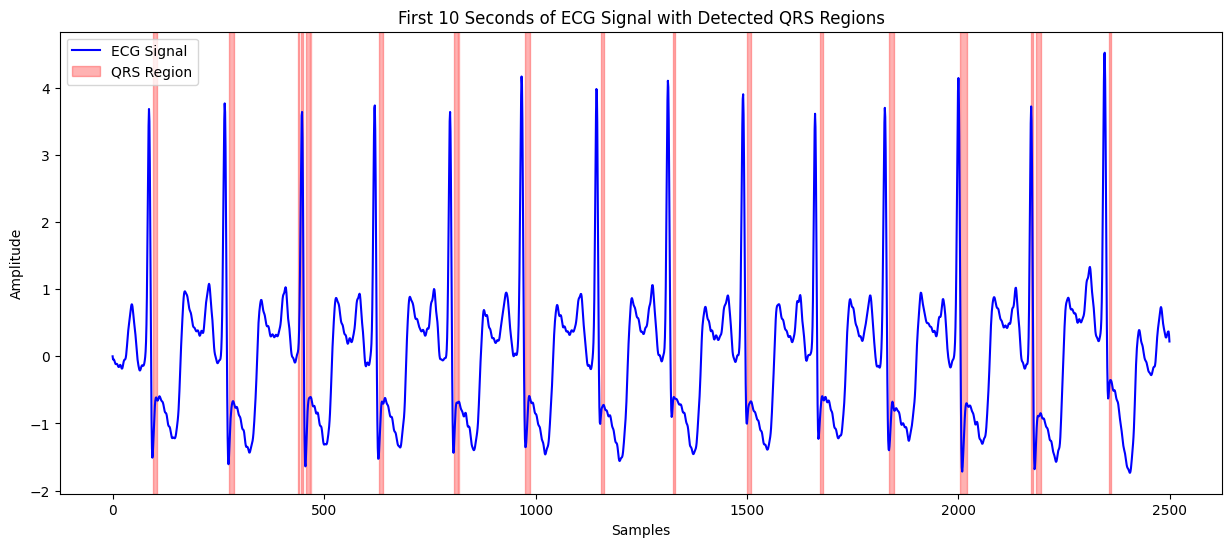

In [92]:
import matplotlib.pyplot as plt

# Plot the first 10 seconds of the ECG signal
plt.figure(figsize=(15, 6))
plt.plot(first_10_seconds, label='ECG Signal', color='b')

# Highlight QRS regions
for start, end in qrs_regions:
    plt.axvspan(start, end, color='r', alpha=0.3, label='QRS Region' if start == qrs_regions[0][0] else "")

plt.title('First 10 Seconds of ECG Signal with Detected QRS Regions')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
#plt.plot(y_pred[0].flatten(), label='Predicted Mask')
plt.legend()
plt.show()

# signal MIT-DB 210 normalized

In [93]:

# Load the new ECG signal
new_record = wfdb.rdrecord('/content/physionet.org/files/mitdb/1.0.0/210')

new_signal = new_record.p_signal[:, 0]  # Use lead I
new_fs = new_record.fs  # Sampling frequency

# Extract the first 10 seconds
first_10_seconds = new_signal[:int(10 * new_fs)]
print(first_10_seconds.shape)

(3600,)


In [94]:

first_10_seconds = normalize_signal(smooth_signal(bandpass_filter(first_10_seconds)))

first_10_seconds = resample_signal(first_10_seconds, original_fs=new_fs, target_fs=250)
new_fs=250
# Segment the signal into fixed-length windows
def segment_signal(signal, window_size, fs):
    segments = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        segments.append(segment)
    return np.array(segments)

window_size = int(1 * new_fs)  # 1-second window
new_segments = segment_signal(first_10_seconds, window_size, new_fs)

# Reshape for TCN input
new_segments = new_segments.reshape(-1, window_size, 1)
print(new_segments.shape)

(18, 250, 1)


## Norm Model

In [95]:
from keras.saving import save_model,load_model

# Save the trained model
model=load_model("/content/drive/MyDrive/Final project/QRS detection/TCN/Norm_model.keras")

In [96]:
# Predict QRS regions
y_pred = model.predict(new_segments)
print(y_pred)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary masks
print(y_pred[y_pred > 0])  # P
# Combine predictions into a single mask
full_mask = np.zeros(len(first_10_seconds))
for i, segment in enumerate(new_segments):
    start = i * (window_size // 2)
    end = start + window_size
    full_mask[start:end] = np.maximum(full_mask[start:end], y_pred[i].flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step
[[[2.8906509e-02]
  [1.4656863e-02]
  [2.7765326e-02]
  ...
  [2.3079992e-03]
  [7.0826366e-04]
  [3.4593162e-03]]

 [[3.8788911e-02]
  [1.3798603e-02]
  [1.1327401e-02]
  ...
  [1.4952162e-02]
  [4.5437408e-03]
  [1.7873948e-03]]

 [[3.9102983e-02]
  [2.7715476e-02]
  [2.0608647e-02]
  ...
  [2.7239136e-03]
  [1.1149691e-03]
  [1.6552182e-03]]

 ...

 [[4.5152366e-02]
  [3.5407368e-02]
  [3.0352354e-02]
  ...
  [6.0131965e-04]
  [8.7225204e-04]
  [4.3034763e-03]]

 [[2.9886480e-02]
  [1.0611096e-02]
  [6.6483482e-03]
  ...
  [1.4141466e-01]
  [1.4240880e-01]
  [1.5661646e-01]]

 [[1.0727582e-01]
  [9.8300092e-02]
  [7.0220381e-02]
  ...
  [1.2364321e-04]
  [2.5984581e-04]
  [7.8160803e-05]]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]


In [97]:
def extract_qrs_from_mask(mask):
    qrs_regions = []
    start = None
    for i in range(len(mask)):
        if mask[i] == 1 and start is None:  # Start of QRS region
            start = i
        elif mask[i] == 0 and start is not None:  # End of QRS region
            end = i
            qrs_regions.append((start, end))
            start = None
    return qrs_regions

qrs_regions = extract_qrs_from_mask(full_mask)
print(qrs_regions)

[(36, 42), (50, 51), (170, 172), (180, 186), (334, 341), (428, 429), (434, 435), (442, 447), (595, 596), (597, 602), (748, 749), (895, 896), (913, 916), (1101, 1102), (1556, 1557), (1733, 1734), (1735, 1736), (1737, 1743), (1749, 1750), (1752, 1753), (1755, 1756), (1901, 1902), (1905, 1909), (2068, 2069), (2071, 2074), (2251, 2254), (2265, 2266)]


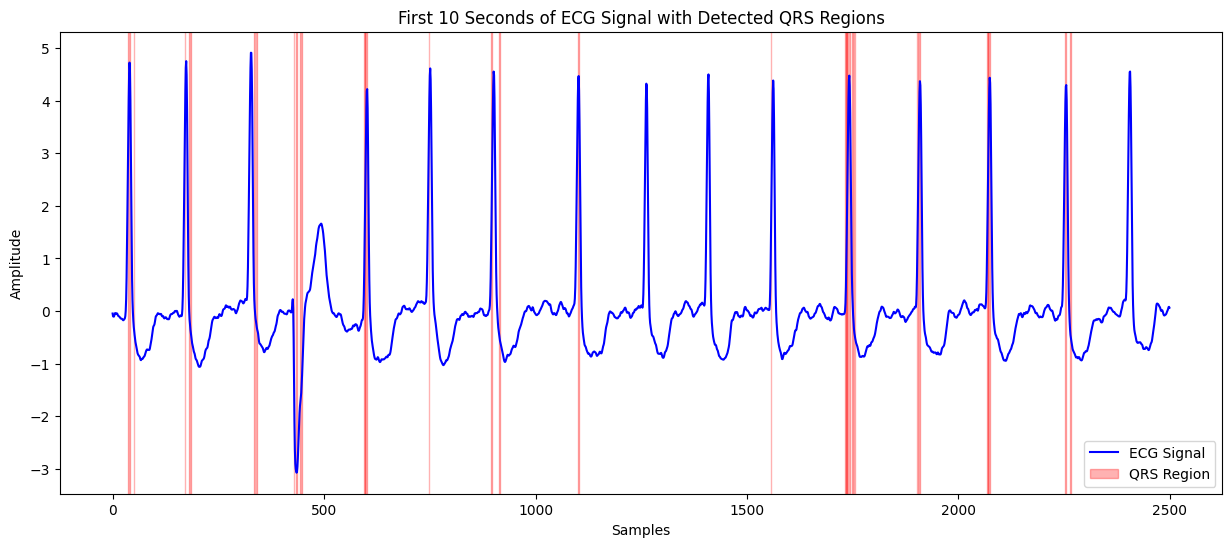

In [98]:
import matplotlib.pyplot as plt

# Plot the first 10 seconds of the ECG signal
plt.figure(figsize=(15, 6))
plt.plot(first_10_seconds, label='ECG Signal', color='b')

# Highlight QRS regions
for start, end in qrs_regions:
    plt.axvspan(start, end, color='r', alpha=0.3, label='QRS Region' if start == qrs_regions[0][0] else "")

plt.title('First 10 Seconds of ECG Signal with Detected QRS Regions')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
#plt.plot(y_pred[0].flatten(), label='Predicted Mask')
plt.legend()
plt.show()